In [2]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from sklearn.preprocessing import LabelEncoder
import ast

c:\Users\Frank\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [92]:
def string_to_list_of_lists(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: ast.literal_eval(x) if not isinstance(x, list) else x)
    return df

def integer_encode_list(series):
    label_encoder = LabelEncoder()
    
    # Concatenate all the lists in the series to fit the encoder
    concatenated = [item for sublist in series for inner_sublist in sublist for item in inner_sublist if isinstance(item, str)]
    unique_elements = list(set(concatenated))
    label_encoder.fit(unique_elements)
    
    # Transform each list separately and store in a new series
    encoded_series = series.apply(lambda x: [[label_encoder.transform([elem])[0] if isinstance(elem, str) else elem for elem in inner_sublist] for inner_sublist in x])
    
    return encoded_series

def create_graph_instance(tokens, pos_encoded, heads, word_embeddings, article_id):
    sentence_graphs = []
    
    for sentence_tokens, sentence_pos, sentence_heads, sentence_word_embeddings in zip(tokens, pos_encoded, heads, word_embeddings):
        # Create a dictionary to map tokens to their corresponding embeddings
        token_embedding_map = {embedding_tuple[1]: embedding_tuple[2] for embedding_tuple in sentence_word_embeddings}
        
        # Create a list of tuples containing the pos tag and the corresponding word embedding, or zeros if the token has no embedding
        node_features = [(pos, token_embedding_map.get(token, np.zeros(300))) for pos, token in zip(sentence_pos, sentence_tokens)]
        
        # Create nodes and assign features
        node_features = torch.tensor([([pos] if type(pos) == int else [pos]) + list(embedding) for pos, embedding in node_features], dtype=torch.float).view(-1, 301)
        
        # Convert heads from string to int and create edges using head indices
        sentence_heads = list(map(int, sentence_heads))
        edge_index = [[head_idx, idx] for idx, head_idx in enumerate(sentence_heads)]
        
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        
        # Assign article_id as ground truth
        y = torch.tensor([article_id], dtype=torch.long)
        
        # Create Data instance for PyTorch Geometric
        graph = Data(x=node_features, edge_index=edge_index, y=y)
        sentence_graphs.append(graph)
    
    return sentence_graphs

def process_dataframe(hdf5_path):
    # Load the dataframe from the hdf5 file
    df = pd.read_hdf(hdf5_path)

    # Convert string representations of lists to actual lists
    columns_to_convert = ['pos', 'dep', 'heads', 'tokens', 'word_embeddings']
    for col in columns_to_convert:
        df = string_to_list_of_lists(df, col)

    # Integer encode the pos and dep columns
    pos_encoded = integer_encode_list(df['pos'])
    #dep_encoded = integer_encode_list(df['dep'])

    # Create graphs
    graphs = []
    for i, row in df.iterrows():
        tokens = row['tokens']
        pos = pos_encoded.loc[i]
        #dep = dep_encoded.loc[i]
        heads = row['heads']
        word_embeddings = row['word_embeddings']

        # Check if the current dataframe is a question dataframe
        if 'article_ids' in df.columns:
            if type(row['article_ids']) == np.int64 or type(row['article_ids']) == int:
                graphs.extend(create_graph_instance(tokens, pos, heads, word_embeddings, row['article_ids']))
            else:
                article_ids = ast.literal_eval(row['article_ids'])
                graphs.extend(create_graph_instance(tokens, pos, heads, word_embeddings, article_ids))
        else:
            article_id = row['id']
            graphs.extend(create_graph_instance(tokens, pos, heads, word_embeddings, article_id))

    return graphs

In [53]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph(graph):
    # Convert PyTorch Geometric graph to a NetworkX graph
    g = nx.Graph()
    edge_index = graph.edge_index.cpu().numpy()
    for src, tgt in edge_index.T:
        g.add_edge(src, tgt)

    # Draw the graph
    pos = nx.spring_layout(g)
    nx.draw(g, pos, node_color="skyblue", edge_color="gray", with_labels=True, font_weight="bold")

    # Show the plot
    plt.show()

In [67]:
q_test_graphs = process_dataframe("../../local_datasets/bsard_extra/gsard_expert_questions_test.h5")
q_train_graphs = process_dataframe("../../local_datasets/bsard_extra/gsard_expert_questions_train.h5")

In [93]:
q_synth_graphs = process_dataframe("../../local_datasets/bsard_extra/gsard_expert_questions_synth.h5")

In [123]:
article_sentence_graphs = process_dataframe("../../local_datasets/bsard_extra/gsard_articles.h5")

In [124]:
def create_article_graph(tokens, pos_encoded, heads, word_embeddings, article_id):
    # Concatenate all sentences in the article
    concatenated_tokens = [token for sentence in tokens for token in sentence]
    concatenated_pos = [pos for sentence in pos_encoded for pos in sentence]
    concatenated_heads = [head for sentence in heads for head in sentence]
    concatenated_word_embeddings = [embedding for sentence in word_embeddings for embedding in sentence]

    # Create a dictionary to map tokens to their corresponding embeddings
    token_embedding_map = {embedding_tuple[1]: embedding_tuple[2] for embedding_tuple in concatenated_word_embeddings}

    # Create a list of tuples containing the pos tag and the corresponding word embedding, or zeros if the token has no embedding
    node_features = [(pos, token_embedding_map.get(token, np.zeros(300))) for pos, token in zip(concatenated_pos, concatenated_tokens)]

    # Create nodes and assign features
    node_features = torch.tensor([([pos] if type(pos) == int else [pos]) + list(embedding) for pos, embedding in node_features], dtype=torch.float).view(-1, 301)

    # Convert heads from string to int and create edges using head indices
    concatenated_heads = list(map(int, concatenated_heads))
    edge_index = [[head_idx, idx] for idx, head_idx in enumerate(concatenated_heads)]

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    # Assign article_id as ground truth
    y = torch.tensor([article_id], dtype=torch.long)

    # Create Data instance for PyTorch Geometric
    graph = Data(x=node_features, edge_index=edge_index, y=y)

    return [graph]

def process_articles_dataframe(hdf5_path):
    # Load the dataframe from the hdf5 file
    df = pd.read_hdf(hdf5_path)

    # Convert string representations of lists to actual lists
    columns_to_convert = ['pos', 'dep', 'heads', 'tokens', 'word_embeddings']
    for col in columns_to_convert:
        df = string_to_list_of_lists(df, col)

    # Integer encode the pos and dep columns
    pos_encoded = integer_encode_list(df['pos'])
    #dep_encoded = integer_encode_list(df['dep'])

    # Create graphs
    graphs = []
    for i, row in df.iterrows():
        tokens = row['tokens']
        pos = pos_encoded.loc[i]
        #dep = dep_encoded.loc[i]
        heads = row['heads']
        word_embeddings = row['word_embeddings']

        # Adjust heads for the entire article
        adjusted_heads = []
        prev_sentence_len = 0
        for sentence_heads in heads:
            adjusted_sentence_heads = [head + prev_sentence_len for head in sentence_heads]
            adjusted_heads.append(adjusted_sentence_heads)  # Change this line to append the list instead of extending it
            prev_sentence_len += len(sentence_heads)

        # Check if the current dataframe is a question dataframe
        if 'article_ids' in df.columns:
            if type(row['article_ids']) == np.int64 or type(row['article_ids']) == int:
                graphs.extend(create_article_graph(tokens, pos, adjusted_heads, word_embeddings, row['article_ids']))
            else:
                article_ids = ast.literal_eval(row['article_ids'])
                graphs.extend(create_article_graph(tokens, pos, adjusted_heads, word_embeddings, article_ids))
        else:
            article_id = row['id']
            graphs.extend(create_article_graph(tokens, pos, adjusted_heads, word_embeddings, article_id))

    return graphs

In [125]:
article_graphs = process_articles_dataframe("../../local_datasets/bsard_extra/gsard_articles.h5")

In [121]:
article_graphs

[Data(x=[15, 301], edge_index=[2, 15], y=[1]),
 Data(x=[579, 301], edge_index=[2, 579], y=[1]),
 Data(x=[222, 301], edge_index=[2, 222], y=[1]),
 Data(x=[537, 301], edge_index=[2, 537], y=[1]),
 Data(x=[141, 301], edge_index=[2, 141], y=[1]),
 Data(x=[110, 301], edge_index=[2, 110], y=[1]),
 Data(x=[22, 301], edge_index=[2, 22], y=[1]),
 Data(x=[21, 301], edge_index=[2, 21], y=[1]),
 Data(x=[74, 301], edge_index=[2, 74], y=[1]),
 Data(x=[161, 301], edge_index=[2, 161], y=[1]),
 Data(x=[28, 301], edge_index=[2, 28], y=[1]),
 Data(x=[85, 301], edge_index=[2, 85], y=[1]),
 Data(x=[257, 301], edge_index=[2, 257], y=[1]),
 Data(x=[146, 301], edge_index=[2, 146], y=[1]),
 Data(x=[92, 301], edge_index=[2, 92], y=[1]),
 Data(x=[38, 301], edge_index=[2, 38], y=[1]),
 Data(x=[68, 301], edge_index=[2, 68], y=[1]),
 Data(x=[22, 301], edge_index=[2, 22], y=[1]),
 Data(x=[192, 301], edge_index=[2, 192], y=[1]),
 Data(x=[179, 301], edge_index=[2, 179], y=[1]),
 Data(x=[55, 301], edge_index=[2, 55], y

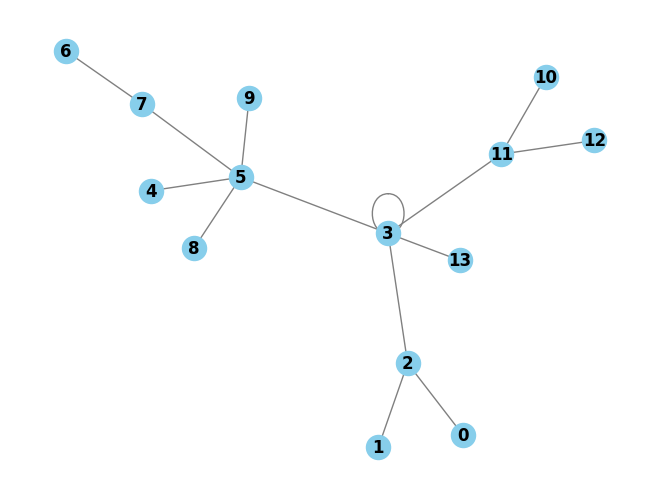

In [127]:
visualize_graph(article_sentence_graphs[1])

In [129]:
torch.save(q_test_graphs, '../../local_datasets/bsard_extra/q_test_graphs.pt')
torch.save(q_train_graphs, '../../local_datasets/bsard_extra/q_train_graphs.pt')
torch.save(q_synth_graphs, '../../local_datasets/bsard_extra/q_synth_graphs.pt')
torch.save(article_sentence_graphs, '../../local_datasets/bsard_extra/article_sentence_graphs.pt')
torch.save(article_graphs, '../../local_datasets/bsard_extra/article_graphs.pt')